## 환경설정 및 패키지 설치

/var/folders/2y/t2fct91n6c515y6sv4v690lc0000gn/T/ipykernel_75087/2927597290.py:47: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


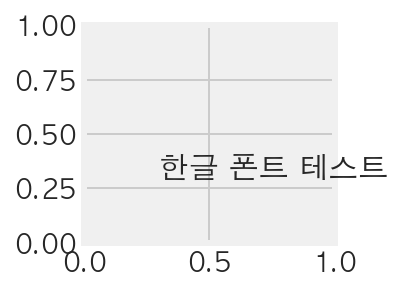

In [1]:
# Data processing
# ==============================================================================
import os 
import datatable


import pandas as pd
import numpy as np
import openpyxl
import math
import datetime as dt

# Plots
# ==============================================================================
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid',font_scale=1.2) 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

## * 이 셀이 제대로 작동하지 않고 길게 warning 메시지가 나올 경우, 상단의 메뉴에서 <런타임>-<런타임 다시 시작>을 클릭한 뒤 처음부터 코드를 실행하세요 
# 그래프 한글 폰트 설정

import matplotlib 
import platform 
from matplotlib import font_manager, rc 
%config InlineBackend.figure_format = 'retina'

# '-' 부호가 제대로 표시되게 하는 설정 
matplotlib.rcParams['axes.unicode_minus'] = False
# 운영 체제마다 한글이 보이게 하는 설정 
if platform.system() == 'Windows': # 윈도우
    path = "c:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc('font', family=font_name)
elif platform.system() == 'Darwin': #맥
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux': # 리눅스
    rc('font', family='NanumBarunGothic')

#폰트 선명하게 보이게 하기 위해
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

## Test
plt.figure(figsize=(2,2))
plt.text(0.3, 0.3, '한글 폰트 테스트', size=15)
plt.show() 

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

## 데이터 불러오기 

In [2]:

############################### 결측처리된 데이터 ##############################
train = pd.read_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/전처리데이터/전처리DATA/train_test전처리1/train_1011_2.csv', encoding='utf-8') 
test = pd.read_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/전처리데이터/전처리DATA/train_test전처리1/test_1011_2.csv', encoding='utf-8')
############################################################################

################################## 외부 데이터 ################################
NaverKeywords = pd.read_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/외부데이터/NaverKeywords.csv') 
log_data_train = pd.read_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/전처리데이터/LOGDATA/log_new_1013/log_new_1013_train.csv') # 10/10 ver
log_data_test = pd.read_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/전처리데이터/LOGDATA/log_new_1013/log_new_1013_test.csv') # 10/10 ver
cofix=pd.read_excel("/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/외부데이터/COFIX.xlsx") 
cofix = cofix.iloc[1:] 
############################################################################

In [3]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())
print(NaverKeywords.isna().sum().sum())
print(log_data_train.isna().sum().sum())
print(log_data_test.isna().sum().sum())
print(cofix.isna().sum().sum()) 

0
3255482
0
24273
16000
0


In [4]:
test['is_applied'].isna().sum()

3255482

## 중요 파생변수  - popularity, group

In [5]:
def add_popularity(train, test):     
    
    full_data = pd.concat([train, test], axis=0).reset_index(drop=True)
    train_index = train.shape[0] 
    
    full_data['is_applied'] = full_data['is_applied'].astype(float)
    
    ## popularity 계산을 위해 loanapply_insert_time -> loanapply_insert_time (초 단위), 이후 제거 
    refer_time = dt.datetime(2022, 2, 28) 
    full_data['loanapply_insert_time'] = pd.to_datetime(full_data['loanapply_insert_time']) 
    full_data['loanapply_insert_time_s'] = (full_data['loanapply_insert_time'] - refer_time).dt.total_seconds().astype(int)  
    
    ## bank_popularity: 은행의 인기도 
    full_data['bank_cumcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('bank_id').cumcount() + 1
    full_data['bank_cumappliedcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('bank_id')['is_applied'].cumsum()
    full_data['bank_popularity'] = full_data['bank_cumappliedcnt'] / full_data['bank_cumcnt'] 
    full_data.drop(['bank_cumappliedcnt'],axis=1,inplace=True) 
    full_data[['bank_cumcnt','bank_popularity']].fillna(0, inplace=True)
    print('bank_cumcnt is done.')
    print('bank_popularity is done.')
    
    ## product_popularity: 상품의 인기도 
    full_data['product_cumcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('product_id').cumcount() + 1
    full_data['product_cumappliedcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('product_id')['is_applied'].cumsum()
    full_data['product_popularity'] = full_data['product_cumappliedcnt'] / full_data['product_cumcnt'] 
    full_data.drop(['product_cumappliedcnt'],axis=1,inplace=True) 
    full_data[['product_cumcnt','product_popularity']].fillna(0, inplace=True)
    print('product_cumcnt is done.') 
    print('product_popularity is done.')
    
    full_data['is_applied'] = full_data['is_applied'].fillna(-1).astype(int).astype(str).replace('-1', np.nan)
    
    train = full_data.loc[full_data.index.isin(np.arange(train_index))]
    test = full_data.loc[~full_data.index.isin(np.arange(train_index))]
    
    return train, test

In [6]:
def popularity_ReplaceTestNA(train, test):  
    
    
    data = pd.concat([train, test], axis=0).reset_index(drop=True)
    train_index = train.shape[0] 
    
    ## 1) bank_popularity NA 처리 

    
#     #만일 bank_popularity, product_popularity Na 있으면, loan_rate 차이 적은 bank_id, product_id 의 popularity로 대체 
#     full_data['bank_popularity'].fillna((full_data['bank_popularity'].mean()), inplace=True)
#     full_data['product_popularity'].fillna((full_data['product_popularity'].mean()), inplace=True)

#     full_data['is_applied'] = full_data['is_applied'].astype(float)
    
    # bank_popularity 가 결측이면 
    if data['bank_popularity'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 bank_id 일 경우 
        data['bank_popularity'] = data.groupby('bank_id')['bank_popularity'].ffill()  # train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        
        
        # 케이스 2) train에 없는 새로 생긴 bank_id 일 경우
        
        # bank_popularity 가 NA인 user_id 리스트 
        na_banks = list(set(data.loc[data['bank_popularity'].isna(), 'bank_id']))
        notNA_df = data[data['bank_popularity'].notna()] 

        for i in range(len(na_banks)): 

            ## 현재 NA인 bank_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['bank_id'] == na_banks[i],'loan_rate'].max() 
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['bank_id'] == na_banks[i], 'bank_popularity'] = np.nanmean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_popularity")])
        print('bank_popularity NA is done.') 
        
    
    ## 2) product_popularity  NA 처리 
    if data['product_popularity'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 product_id 일 경우 
        data['product_popularity'] = data.groupby('product_id')['product_popularity'].ffill()  # train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        
    
        # 케이스 2) train에 없는 새로 생긴 product_id 일 경우
    
        # product_popularity 가 NA인 user_id 리스트 
        na_products = list(set(data.loc[data['product_popularity'].isna(), 'product_id']))
        notNA_df = data[data['product_popularity'].notna()]

        for i in range(len(na_products)): 
            
            ## 현재 NA인 product_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()
            
#             # loan_rate 차이가 최소인 열 구하기 
#             min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
#             # 그 열들의 평균 bank_popularity 
#             data.loc[data['product_id'] == na_products[i], 'product_popularity'] = np.nanmean(
#                     notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_popularity")])

            # loan_rate 차이가 최소인 값 구하기 
            min_diff = (loan_rate_NA_max - notNA_df['loan_rate']).abs().min()
            # 그 값을 갖는 열들의 평균 bank_popularity 
            data.loc[data['product_id'] == na_products[i], 'product_popularity'] = np.median(
                notNA_df.loc[(loan_rate_NA_max - notNA_df['loan_rate']).abs() == min_diff, 'product_popularity']) 
        print('product_popularity NA is done.')     
            
    
    train = data.loc[data.index.isin(np.arange(train_index))]
    test = data.loc[~data.index.isin(np.arange(train_index))]
    
    return train, test 

In [7]:
train_merged, test_merged = add_popularity(train, test)
train_merged, test_merged = popularity_ReplaceTestNA(train_merged, test_merged)

bank_cumcnt is done.
bank_popularity is done.
product_cumcnt is done.
product_popularity is done.
bank_popularity NA is done.
product_popularity NA is done.


In [8]:
## 잘 되었는지 확인 
print(train_merged.isna().sum().sum()) 
print(test_merged.isna().sum().sum()) 

# 원래 존재하는 NA 
print(test_merged['is_applied'].isna().sum()) 
print(test_merged['yearly_income'].isna().sum()) 

# 0인지 확인 
print(test_merged['bank_popularity'].isna().sum()) 
print(test_merged['product_popularity'].isna().sum()) 

0
3255482
3255482
0
0
0


In [9]:
# 은행 분류 정의 (EDA 결과를 바탕으로)
bank_cluster1= [55, 14, 44, 21, 42, 38, 34, 46, 29, 39, 15, 6, 61, 64, 13, 57, 32, 20, 35, 59, 31, 50, 27, 7, 25, 36, 1, 26, 24, 54, 22, 49, 8, 37, 58, 12, 43, 19, 33, 47, 30, 28, 10, 41, 18, 62, 17, 5, 63, 23, 11, 51, 45, 40, 56, 4, 2, 16, 52, 9]
bank_cluster2= [29, 55, 42, 3, 46, 21, 14, 64, 15, 20, 57, 39, 35, 52, 44, 27, 59, 8, 45, 54, 50, 43, 26, 1, 61, 49, 31, 37, 58, 12, 36, 7, 25, 38, 19, 47, 18, 22, 62, 30, 5, 33, 24, 63, 23, 32, 40, 60, 28, 41, 56, 4, 16, 17, 2, 9]
bank_cluster3= [13, 55, 35, 38, 64, 15, 34, 3, 6, 24, 14, 44, 37, 46, 21, 32, 57, 61, 42, 1, 43, 36, 20, 59, 25, 22, 50, 11, 26, 54, 49, 7, 31, 58, 12, 19, 33, 30, 47, 28, 10, 41, 17, 5, 63, 23, 40, 51, 56, 2]

# 대출상품 분류 정의 (EDA 결과를 바탕으로)
product_cluster1= [12, 128, 171, 196, 216, 113, 8, 215, 140, 197, 227, 265, 62, 204, 36, 92, 25, 258, 141, 254, 186, 262, 71, 56, 111, 249, 51, 15, 38, 150, 239, 174, 142, 176, 220, 191, 245, 90, 185, 163, 192, 67, 61, 80, 263, 259, 157, 82, 70, 1, 221, 60, 91, 39, 144, 31, 107, 206, 243, 175, 29, 68, 58, 224, 35, 246, 168, 147, 231, 264, 110, 138, 121, 235, 217, 266, 267, 96, 149, 65, 222, 26, 223, 16, 139, 114, 49, 78, 85, 40, 131, 200, 19, 194, 226, 233, 236, 108, 170, 169, 162, 270, 57, 20, 43, 247, 86, 22, 161, 129, 146, 252, 94, 98, 30, 79, 5, 81, 240, 59, 248, 123, 268, 137, 93, 42, 124, 24, 211, 238, 100, 126, 7, 181, 166, 187, 159, 250]
product_cluster2= [265, 25, 258, 205, 227, 196, 128, 254, 152, 141, 111, 12, 71, 62, 216, 197, 38, 249, 234, 171, 148, 251, 187, 91, 270, 119, 259, 22, 31, 142, 246, 80, 90, 8, 185, 1, 144, 245, 92, 195, 136, 244, 206, 39, 175, 140, 68, 61, 35, 15, 60, 191, 75, 224, 163, 58, 103, 134, 127, 47, 223, 16, 78, 235, 131, 188, 94, 176, 49, 138, 96, 164, 200, 48, 121, 194, 189, 229, 20, 226, 184, 236, 266, 257, 261, 129, 267, 157, 183, 63, 217, 51, 110, 174, 30, 263, 161, 222, 162, 5, 108, 59, 67, 268, 137, 225, 264, 233, 42, 147, 168, 146, 166, 220, 238, 19, 26, 7, 181, 55, 250, 105, 190]
product_cluster3= [123, 12, 29, 262, 113, 254, 204, 215, 15, 205, 36, 263, 197, 239, 152, 8, 192, 38, 141, 206, 186, 25, 227, 140, 196, 56, 71, 92, 128, 258, 171, 61, 246, 157, 111, 67, 150, 169, 221, 216, 142, 118, 80, 163, 107, 70, 168, 245, 81, 1, 259, 39, 191, 220, 174, 266, 243, 249, 175, 35, 90, 68, 159, 185, 60, 51, 144, 161, 91, 231, 110, 85, 138, 86, 217, 49, 98, 223, 16, 65, 149, 235, 57, 139, 222, 264, 40, 19, 194, 100, 43, 226, 170, 79, 108, 236, 233, 129, 252, 26, 162, 267, 224, 147, 46, 30, 5, 124, 248, 247, 121, 114, 58, 137, 126, 93, 24, 146, 7, 181]

    
## bank_group: bank의 loan_rate, loan_limit을 기준으로 그룹핑 
def BankProductGroups(data, variable, cluster1, cluster2, cluster3):
    
    ## 차집합을 이용해 7개의 클러스터로 나눔
    c123 = list(set(cluster1) & set(cluster2) & set(cluster3)) 

    c1 = list((set(cluster1) - set(cluster2)) - set(cluster3))
    c2 = list((set(cluster2) - set(cluster3)) - set(cluster1))
    c3 = list((set(cluster3) - set(cluster1)) - set(cluster2))

    c12 = list((set(cluster1) & set(cluster2)) - set(c123))
    c23 = list((set(cluster2) & set(cluster3)) - set(c123))
    c31 = list((set(cluster3) & set(cluster1)) - set(c123))

    clusters_list = [c1, c2, c3, c12, c23, c31, c123]

    ## 내용이 없는 클러스터일 경우 삭제 
    clusters_list = [cluster for cluster in clusters_list if cluster != []]
#     print(clusters_list)
    
    ## bank_group, product_group: bank_id 를 loan_rate,loan_limit 이용해 clustering 한 결과 
    for i, value in enumerate(clusters_list):
        
        # 각 group 에 속한 bank_id 혹은 product_id 를 확인할 수 있음 
#         print(str(variable), 'cluster: ', (i+1), value)
        print('cluster ', str(i), 'len: ', len(value), '\n', value)
        
        if variable == 'bank_id':
            data.loc[data[variable].isin(value), 'bank_group'] = i+1
        elif variable == 'product_id':
            data.loc[data[variable].isin(value), 'product_group'] = i+1 
    
    print(str(variable), 'group done.') 
    print('\n')

    return data 

In [10]:
def bpGroup_ReplaceTestNA(train, test):  
    
    
    data = pd.concat([train, test], axis=0).reset_index(drop=True)
    train_index = train.shape[0] 
    
    ## 1) bank_group NA 처리 
    
    # bank_group 가 결측이면 
    if data['bank_group'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 bank_id 일 경우 
        ## train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        
        data['bank_group'] = data.groupby('bank_id')['bank_group'].ffill()  
        
        # 케이스 2) train에 없는 새로 생긴 bank_id 일 경우
        
        # bank_popularity 가 NA인 user_id 리스트 
        na_banks = list(set(data.loc[data['bank_group'].isna(), 'bank_id']))
        notNA_df = data[data['bank_group'].notna()] 

        for i in range(len(na_banks)): 

            ## 현재 NA인 bank_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['bank_id'] == na_banks[i],'loan_rate'].max() 
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['bank_id'] == na_banks[i], 'bank_group'] = np.nanmean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_group")])
        print('bank_group NA is done.') 
        
    
    ## 2) product_group  NA 처리 
    if data['product_group'].isna().sum() != 0 : 
        
        # 케이스 1) train에 존재하는 product_id 일 경우 
        # train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        data['product_group'] = data.groupby('product_id')['product_group'].ffill()  
    
        # 케이스 2) train에 없는 새로 생긴 product_id 일 경우
    
        # product_popularity 가 NA인 user_id 리스트 
        na_products = list(set(data.loc[data['product_group'].isna(), 'product_id']))
        notNA_df = data[data['product_group'].notna()]

        for i in range(len(na_products)): 
            
            ## 현재 NA인 product_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['product_id'] == na_products[i], 'product_group'] = np.nanmean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_group")])
        print('product_group NA is done.')     
            
    
    train = data.loc[data.index.isin(np.arange(train_index))]
    test = data.loc[~data.index.isin(np.arange(train_index))]
    
    return train, test 

In [11]:
## train 적용 
train_merged1 = BankProductGroups(train_merged, 'bank_id', bank_cluster1, bank_cluster2, bank_cluster3)
train_merged1 = BankProductGroups(train_merged, 'product_id', product_cluster1, product_cluster2, product_cluster3)

## test 적용 
test_merged1 = BankProductGroups(test_merged, 'bank_id', bank_cluster1, bank_cluster2, bank_cluster3)
test_merged1 = BankProductGroups(test_merged, 'product_id', product_cluster1, product_cluster2, product_cluster3)

## test NA 처리
test_merged1, test_merged1 = bpGroup_ReplaceTestNA(test_merged1, test_merged1) 

cluster  0 len:  1 
 [60]
cluster  1 len:  11 
 [4, 39, 8, 9, 45, 16, 18, 52, 27, 29, 62]
cluster  2 len:  1 
 [3]
cluster  3 len:  6 
 [34, 6, 10, 11, 13, 51]
cluster  4 len:  43 
 [1, 2, 5, 7, 12, 14, 15, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 46, 47, 49, 50, 54, 55, 56, 57, 58, 59, 61, 63, 64]
bank_id group done.


cluster  0 len:  3 
 [240, 82, 211]
cluster  1 len:  26 
 [257, 261, 134, 136, 148, 164, 47, 48, 55, 184, 183, 188, 189, 190, 63, 195, 75, 225, 229, 103, 105, 234, 244, 119, 251, 127]
cluster  2 len:  2 
 [46, 118]
cluster  3 len:  19 
 [131, 265, 268, 270, 20, 22, 31, 166, 42, 176, 187, 59, 62, 200, 78, 94, 96, 238, 250]
cluster  4 len:  2 
 [152, 205]
cluster  5 len:  40 
 [262, 139, 149, 150, 24, 29, 159, 36, 40, 169, 170, 43, 56, 57, 186, 192, 65, 70, 204, 79, 81, 85, 86, 215, 93, 221, 98, 100, 231, 107, 239, 113, 114, 243, 252, 247, 248, 123, 124, 126]
cluster  6 len:  76 
 [128, 1, 129, 258, 259, 5, 7, 8, 137, 138

In [12]:
test_merged1[test_merged1['bank_group'].isna()]

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,existing_loan_cnt,existing_loan_amt,isjob,loanapply_insert_time_s,bank_cumcnt,bank_popularity,product_cumcnt,product_popularity,bank_group,product_group


In [13]:
## 잘 되었는지 확인 
print('Train bank_group')
print(train_merged1['bank_group'].value_counts(dropna=False), '\n')
print('Train product_group')
print(train_merged1['product_group'].value_counts(dropna=False), '\n')

print('Test bank_group')
print(test_merged1['bank_group'].value_counts(dropna=False), '\n')
print('Test product_group')
print(test_merged1['product_group'].value_counts(dropna=False)) 

Train bank_group
5.0    7773863
4.0    1232878
2.0    1110427
3.0     116568
1.0      30613
Name: bank_group, dtype: int64 

Train product_group
7.0    5119141
6.0    2503314
2.0    1523626
4.0     883047
3.0     118166
5.0     116568
1.0        487
Name: product_group, dtype: int64 

Test bank_group
5.0    2476405
2.0     380347
4.0     354613
3.0      34729
1.0       9388
Name: bank_group, dtype: int64 

Test product_group
7.0    1664622
6.0     777890
2.0     458250
4.0     280084
3.0      39798
5.0      34729
1.0        109
Name: product_group, dtype: int64


In [14]:
test_merged1.loc[test_merged1.bank_group.isna()].bank_id.value_counts()

Series([], Name: bank_id, dtype: int64)

In [15]:
test_merged1.loc[test_merged1.product_group.isna()].product_id.value_counts()

Series([], Name: product_id, dtype: int64)

In [16]:
## 잘 되었는지 확인 
# train_merged6 
print(train_merged1['is_applied'].isna().sum()) 
print(train_merged1['bank_popularity'].isna().sum()) 
print(train_merged1['product_popularity'].isna().sum()) 

# 원래 존재하는 NA 
print(test_merged1['is_applied'].isna().sum()) 
print(test_merged1['yearly_income'].isna().sum()) 

# 0인지 확인 
print(test_merged1['bank_popularity'].isna().sum()) 
print(test_merged1['product_popularity'].isna().sum()) 

0
0
0
3255482
0
0
0


## 네이버키워드 데이터
### 네이버키워드 데이터 병합을 위한 전처리

네이버 통합 검색어 트렌드 데이터 설명
- ages 변수: 
    - 1: 0∼12세, 2: 13∼18세, 3: 19∼24세, 4: 25∼29세, 5: 30∼34세, 6: 35∼39세, 7: 40∼44세, 8: 45∼49세, 9: 50∼54세, 10: 55∼59세, 11: 60세 이상

In [17]:
## 0) 날짜형 변환 
NaverKeywords['date'] = pd.to_datetime(NaverKeywords['date'])
NaverKeywords['date'] = pd.to_datetime(NaverKeywords['date'])

## 1) 네이버키워드 데이터 열이름 변경 
NaverKeywords.rename(columns={'gender':'gender2', 'age':'age_band'}, inplace=True)

NaverKeywords.head(2)

,date,gender2,age_band,대출총괄_mo,대출총괄_pc,주택관련대출_mo,주택관련대출_pc,자동차대출_mo,자동차대출_pc,대환대출_mo,대환대출_pc,핀다대출외서비스_mo,핀다대출외서비스_pc
0,2022-02-01,f,2,3.07017,0.0,0.43859,0.0,2.19298,3.40909,0.00000,0.0,0.73099,0.0
1,2022-02-01,m,2,6.70103,0.0,6.70103,0.0,11.85567,10.00000,0.51546,0.0,2.06185,10.0


### 기존 train/test와 네이버키워드 데이터를 병합

In [18]:
def NaverMerge(data):
    
    from datetime import timedelta
    
    ## 0) 날짜형 변환 
    data['loanapply_insert_time'] = pd.to_datetime(data['loanapply_insert_time'])
    data['insert_time'] = pd.to_datetime(data['insert_time'])
    
    ## 1) inser_time 이전일자 계산 
    data['insert_time_lag1'] = data['insert_time'].dt.date - timedelta(days=1)
    data['insert_time_lag1'] = pd.to_datetime(data['insert_time_lag1'])
    
    ## 2) gender 전처리 
    data.loc[data['gender'] == 0, 'gender2'] = 'f'  # train에서 gender 0은 여성 
    data.loc[data['gender'] == 1, 'gender2'] = 'm'  # train에서 gender 1은 여성 
    
    ## 3) age 생성 
    data['age'] = 2022 - data['birth_year'] + 1 
    
    ## 4) age 전처리 -> age_band 생성 
    ## 네이버 통합 검색어 트렌드 데이터 설명 참고 (https://developers.naver.com/)
    data.loc[(data['age'] >= 0) & (data['age'] <= 12), 'age_band'] = 1  
    data.loc[(data['age'] >= 13) & (data['age'] <= 18), 'age_band'] = 2
    data.loc[(data['age'] >= 19) & (data['age'] <= 24), 'age_band'] = 3
    data.loc[(data['age'] >= 25) & (data['age'] <= 29), 'age_band'] = 4
    data.loc[(data['age'] >= 30) & (data['age'] <= 34), 'age_band'] = 5 
    data.loc[(data['age'] >= 35) & (data['age'] <= 39), 'age_band'] = 6
    data.loc[(data['age'] >= 40) & (data['age'] <= 44), 'age_band'] = 7
    data.loc[(data['age'] >= 45) & (data['age'] <= 49), 'age_band'] = 8
    data.loc[(data['age'] >= 50) & (data['age'] <= 54), 'age_band'] = 9 
    data.loc[(data['age'] >= 55) & (data['age'] <= 59), 'age_band'] = 10
    data.loc[(data['age'] >= 60), 'age_band'] = 11

    data['age_band'] = data['age_band'].astype(int) 
    
    
    ## 5) 병합: insert_time의 1일 전 검색량과 병합 
    data_merged = pd.merge(data, NaverKeywords, how='left', 
                        left_on=['insert_time_lag1','gender2','age_band'], right_on=['date','gender2','age_band'])
    
    ## 6) 불필요한 열 제거
    data_merged.drop(['insert_time_lag1','gender2','age_band','date'], axis=1, inplace=True)
    
    ## 7) 진행상황 프린트 
    print('Naver Keywords merged.')    
    
    return data_merged
    

In [19]:
# 시간 소요 유의
train_merged2 = NaverMerge(train_merged1) 
test_merged2 = NaverMerge(test_merged1)

Naver Keywords merged.
Naver Keywords merged.


In [20]:
# 병합 잘 되었는지 확인 
train_merged2[['insert_time','gender','age',
              '대출총괄_mo','대출총괄_pc','주택관련대출_mo','주택관련대출_pc','자동차대출_mo']].head(2)

,insert_time,gender,age,대출총괄_mo,대출총괄_pc,주택관련대출_mo,주택관련대출_pc,자동차대출_mo
0,2022-03-01 00:11:35,1.0,49.0,18.70047,15.23178,35.41996,40.39735,5.86370
1,2022-03-01 00:14:14,0.0,52.0,21.48541,13.75000,44.42970,45.00000,6.36604


In [21]:
train_merged2[['insert_time','gender','age',
              '대출총괄_mo','대출총괄_pc','주택관련대출_mo','주택관련대출_pc','자동차대출_mo']].tail(2)

,insert_time,gender,age,대출총괄_mo,대출총괄_pc,주택관련대출_mo,주택관련대출_pc,자동차대출_mo
10264347,2022-05-30 16:48:09,0.0,48.0,11.12107,3.2258,42.51121,11.29032,3.94618
10264348,2022-05-30 16:48:09,0.0,48.0,11.12107,3.2258,42.51121,11.29032,3.94618


In [22]:
test_merged2[['insert_time','gender','age',
              '대출총괄_mo','대출총괄_pc','주택관련대출_mo','주택관련대출_pc','자동차대출_mo']].head(2)

,insert_time,gender,age,대출총괄_mo,대출총괄_pc,주택관련대출_mo,주택관련대출_pc,자동차대출_mo
0,2022-06-01 00:12:23,0.0,60.0,21.30177,25.64102,29.58579,35.89743,6.21301
1,2022-06-01 00:18:03,0.0,58.0,19.65517,5.40540,60.68965,59.45945,11.72413


In [23]:
test_merged2[['insert_time','gender','age',
              '대출총괄_mo','대출총괄_pc','주택관련대출_mo','주택관련대출_pc','자동차대출_mo']].tail(2)

,insert_time,gender,age,대출총괄_mo,대출총괄_pc,주택관련대출_mo,주택관련대출_pc,자동차대출_mo
3255480,2022-06-30 12:56:53,1.0,29.0,40.68767,41.78674,43.91117,58.50144,11.53295
3255481,2022-06-30 20:36:10,1.0,27.0,40.68767,41.78674,43.91117,58.50144,11.53295


In [24]:
print('train 의 shape: ', train_merged1.shape)
print('train_merged 의 shape: ', train_merged2.shape)

## 5영역의 키워드*2개의 디바이스 = 10개 열 차이가 나야함. 
## 그런데 전처리 과정에서 3개 열('insert_time_lag1','gender2','age_band')을 생성했으므로, 
## 7개 열 차이 나면 문제 없음. 

train 의 shape:  (10264349, 35)
train_merged 의 shape:  (10264349, 42)


In [25]:
# del train_merged
# del test_merged

## 로그데이터
#### train_log 데이터 설명

- 세션의 기준
    - 아무런 활동을 하지 않을 경우 15분 후 만료 
    - 계속 활동할 경우에는 15분 이상인 세션도 있음 

- 범주형: application_id, user_id, mp_os
- 수치형
    - Session: 해당일 기준으로 몇 번째 세션인가, 
    - how_long: 가입한 지 며칠 째인가
    - visit_cumsum: 일자 기준 방문횟수
    - from_last_visit: 재방문 시간(일자 기준)  ----- (from_last_visit_time 과 약간 중복됨)
    - visit_rate: visit_cumsum / how_long(누적 방문횟수 / 가입기간) = 가입기간 대비 얼마나 방문했는가 
    - session_sum: 현재까지의 총 세션 수 (누적)
    - session_avg: 현재까지의 일별 평균 세션 수 
    - 유저 행동 건수_1: CompleteIDCertification_1, EndLoanApply_1, Error_1, Error2_1, GetCreditInfo_1 등 
    - events_1: 유저 행동 순열을 _로 연결한 것
    - cumsum_1: CompleteIDCertification_cumsum_1, EndLoanApply_cumsum_1 등 
    - 유저 행동 건수_2: CompleteIDCertification_2, EndLoanApply_2, Error_2, Error2_2, GetCreditInfo_2 등
    - events_2: 유저 행동 순열을 _로 연결한 것
    - cumsum_2: CompleteIDCertification_cumsum_2, EndLoanApply_cumsum_2 등 
- 날짜형
    - insert_time(ymd hms), date(ymd)
    - connect_time: application을 작성한 시간, 하나의 세션 내에서 첫 번째 행동과 마지막 행동의 시간차(일 시분초 기준) 
    - from_last_visit_time: 재방문 시간(일 시분초 기준) 

### 로그 데이터 병합을 위한 전처리

In [26]:
log_data_train.columns

Index(['application_id', 'user_id', 'insert_time', 'mp_os', 'Session', 'date',
       'how_long', 'visit_cumsum', 'from_last_visit', 'visit_rate',
       'session_sum', 'session_avg', 'before_apply_count', 'before_7days',
       'before_30days', 'event_count1', 'event_group1', 'connect_time_s',
       'from_last_visit_time_s', 'Error2', 'OpenApp', 'GetCreditInfo',
       'UseLoanManage', 'UsePrepayCalc', 'StartLoanApply',
       'ViewLoanApplyIntro', 'CompleteIDCertification', 'EndLoanApply',
       'Login', 'SignUp', 'UseDSRCalc', 'Error'],
      dtype='object')

In [27]:
log_data_test.columns

Index(['application_id', 'user_id', 'insert_time', 'mp_os', 'Session', 'date',
       'how_long', 'visit_cumsum', 'from_last_visit', 'visit_rate',
       'session_sum', 'session_avg', 'before_apply_count', 'before_7days',
       'before_30days', 'event_count1', 'event_group1', 'connect_time_s',
       'from_last_visit_time_s', 'Error2', 'OpenApp', 'GetCreditInfo',
       'UseLoanManage', 'UsePrepayCalc', 'StartLoanApply',
       'ViewLoanApplyIntro', 'CompleteIDCertification', 'EndLoanApply',
       'Login', 'SignUp', 'UseDSRCalc', 'Error'],
      dtype='object')

In [28]:
# ## '_2'로 끝나는 컬럼 삭제 
# log_data_test2.loc[:, ~log_data_test2.columns.str.endswith('_2')].head(2)

In [29]:
# ## 1) cumsum_list 

# cumsum_list = log_data_test2.columns[log_data_test2.columns.str.endswith('cumsum_2')] 
# log_data_test2[cumsum_list].columns.str.rstrip('_2') 


In [30]:
## train, test 로그 데이터 병합
log_data = pd.concat([log_data_train, log_data_test], axis=0) 

In [31]:
## 0) 날짜형 변환 
log_data['insert_time'] = pd.to_datetime(log_data['insert_time'])
log_data['date'] = pd.to_datetime(log_data['date']) 

## 0) 변수 삭제 (용량줄이기) 

## 1) mp_os 변수 결측치 "unknown"으로 채우기 
log_data['mp_os'].fillna("unknown", inplace=True)

# ## 2) 초 단위로 connect_time, from_last_visit_time 변환 
# log_data['connect_time_s'] = (pd.to_timedelta(log_data['connect_time']) / np.timedelta64(1, 's')).astype(int)
# log_data['from_last_visit_time_s'] =(pd.to_timedelta(log_data['from_last_visit_time']) / np.timedelta64(1, 's')).astype(int)
# log_data.drop(['connect_time','from_last_visit_time'], axis=1,inplace=True)

## 3) 병합을 위해 데이터형 변환 
log_data['application_id'] = log_data['application_id'].astype(int)
log_data['insert_time'] = pd.to_datetime(log_data['insert_time']) 

In [32]:
log_data.head(2)

,application_id,user_id,insert_time,mp_os,Session,date,how_long,visit_cumsum,from_last_visit,visit_rate,...,UseLoanManage,UsePrepayCalc,StartLoanApply,ViewLoanApplyIntro,CompleteIDCertification,EndLoanApply,Login,SignUp,UseDSRCalc,Error
0,248576,9,2022-05-21 23:41:09,Android,1.0,2022-05-21,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1180616,11,2022-03-24 10:58:22,iOS,1.0,2022-03-24,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
print(log_data_train.shape)
print(log_data_test.shape)
print(log_data.shape)  # connect_time_s, from_last_visit_time_s 가 생성되어 

(728860, 32)
(239865, 32)
(968725, 32)


In [34]:
# # _1 로 끝나는 변수들 
# train_log.columns[train_log.columns.str.endswith('_1')]

### 기존 train/test와 log 데이터를 병합

In [35]:
def LogMerge(data):
    
    data_merged = pd.merge(data, log_data.drop(['date'], axis=1),
                         how='left', on=['application_id','user_id','insert_time'])  
    
    print('Log Data merged.')
    
    return data_merged

In [36]:
train_merged_log = LogMerge(train_merged2)
test_merged_log = LogMerge(test_merged2) 

Log Data merged.
Log Data merged.


In [37]:
# 잘 병합되었는지, na는 없는지 체크 
print(train_merged_log['connect_time_s'].isna().sum())
print(train_merged_log['from_last_visit_time_s'].isna().sum())

print(test_merged_log['connect_time_s'].isna().sum())
print(test_merged_log['from_last_visit_time_s'].isna().sum())

0
0
0
0


In [38]:
train_merged_log[['application_id','user_id','loanapply_insert_time','insert_time','Session']].head(2)

,application_id,user_id,loanapply_insert_time,insert_time,Session
0,566528,681184,2022-03-01 00:11:36,2022-03-01 00:11:35,1.0
1,38545,477093,2022-03-01 00:14:15,2022-03-01 00:14:14,1.0


In [39]:
test_merged_log[['application_id','user_id','loanapply_insert_time','insert_time','Session']].head(2)

,application_id,user_id,loanapply_insert_time,insert_time,Session
0,1255231,694012,2022-06-01 00:12:24,2022-06-01 00:12:23,1.0
1,588236,778437,2022-06-01 00:18:03,2022-06-01 00:18:03,1.0


In [40]:
print(train_merged_log.shape)
print(test_merged_log.shape)

(10264349, 70)
(3255482, 70)


In [41]:
train_merged_log.columns 

Index(['application_id', 'loanapply_insert_time', 'bank_id', 'product_id',
       'loan_limit', 'loan_rate', 'is_applied', 'user_id', 'birth_year',
       'gender', 'insert_time', 'credit_score', 'yearly_income', 'income_type',
       'company_enter_month', 'employment_type', 'houseown_type',
       'desired_amount', 'purpose', 'personal_rehabilitation_yn',
       'personal_rehabilitation_complete_yn', 'existing_loan_cnt',
       'existing_loan_amt', 'isjob', 'loanapply_insert_time_s', 'bank_cumcnt',
       'bank_popularity', 'product_cumcnt', 'product_popularity', 'bank_group',
       'product_group', 'age', '대출총괄_mo', '대출총괄_pc', '주택관련대출_mo', '주택관련대출_pc',
       '자동차대출_mo', '자동차대출_pc', '대환대출_mo', '대환대출_pc', '핀다대출외서비스_mo',
       '핀다대출외서비스_pc', 'mp_os', 'Session', 'how_long', 'visit_cumsum',
       'from_last_visit', 'visit_rate', 'session_sum', 'session_avg',
       'before_apply_count', 'before_7days', 'before_30days', 'event_count1',
       'event_group1', 'connect_time_s', 'from_la

## 날짜형 데이터 전처리

In [42]:
# 1) insert_time 시간대 분류 정의 (EDA 결과를 바탕으로)
hour_c1 = [19,20,21,22,23]  # 19~23, 저녁시간대 
hour_c2 = [11,12,13,14,15,16,17,18] # 11~18, 근무시간대 
hour_c3 = [1,6,7,8,9,10] # 6~10,1, 1과 오전시간대 
hour_c4 = [0,2,3,4,5] # 1 제외 새벽 시간대 

# 2) 공휴일 데이터 불러오기 
is_holiday_df = pd.read_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/외부데이터/df_holiday_2022.csv')
is_holiday_df['yyyymmdd'] = pd.to_datetime(is_holiday_df['yyyymmdd']) 
is_holiday_df.drop(['이름', '요일'],axis=1,inplace=True)

## 공휴일인 일자를 리스트로 저장 
is_holida_list = is_holiday_df['yyyymmdd'].tolist()


In [43]:
# 날짜형 데이터 전처리 (loanapply_insert_time, insert_time 이 결측인 경우가 있어서, 결측 처리 후 전처리 진행)

def DatesPreprocess(data):
    
    ## 0) 날짜형 변환 
    data['loanapply_insert_time'] = pd.to_datetime(data['loanapply_insert_time'])
    data['insert_time'] = pd.to_datetime(data['insert_time'])
    
    ## 1) insert_time -> 월,일,시간,시간대,요일 (5개)
    data['insert_time_month'] = data['insert_time'].dt.month 
    data['insert_time_day'] = data['insert_time'].dt.day 
    data['insert_time_hour'] = data['insert_time'].dt.hour
    data['insert_time_weekday'] = data['insert_time'].dt.weekday

    data.loc[data['insert_time_hour'].isin(hour_c1), 'insert_time_timezone'] = 'evening'
    data.loc[data['insert_time_hour'].isin(hour_c2), 'insert_time_timezone'] = 'working'
    data.loc[data['insert_time_hour'].isin(hour_c3), 'insert_time_timezone'] = 'early morning_w1'
    data.loc[data['insert_time_hour'].isin(hour_c4), 'insert_time_timezone'] = 'dawn_not1' 
    
    ### insert_time과 loanapply_insert_time의 월,일이 모든 열에 대해 정확히 일치하고, 시간차에 따른 타겟변수의 비율차이가 없으므로,
    ### loanapply_insert_time의 날짜 파싱은 진행하지 않음(아래 주석처리된 EDA 참고). 
    
    print('insert_time -> month/day/hour/weekday/timezone done.')

    ## 2) company_enter_month -> 연월 (2개)
    data['company_enter_month_year'] = data['company_enter_month'].astype('str').str[:4]
    data['company_enter_month_month'] = data['company_enter_month'].astype('str').str[4:6].str.lstrip("0")
    
    ### company_enter_month_month: 결측이면 0으로 변환    
    data.replace('', np.nan, inplace=True)
    data['company_enter_month_month'].fillna(0, inplace=True)  
    
    print('company_enter_month -> year/month done.')
    
    ## 3) is_holiday: 공휴일 여부  
    data['yyyymmdd'] = pd.to_datetime(data['insert_time'].dt.date)
    data.loc[data['yyyymmdd'].isin(is_holida_list), 'is_holiday'] = True
    data['is_holiday'].fillna(False, inplace=True)  
    del data['yyyymmdd']
    print('is_holiday done.')
    
    ## 4) 주기 인코딩 
    ## insert_time_weekday : -> sin/cos 변환
    data['insert_time_weekday_sin'] = np.sin(2 * math.pi * data['insert_time_weekday'] / 
                                             data['insert_time_weekday'].max())
    data['insert_time_weekday_cos'] = np.cos(2 * math.pi * data['insert_time_weekday'] /
                                             data['insert_time_weekday'].max())
    print('sin/cos done.')
    
    ## 5) 변수형 변환: insert_time 을 int -> str 변환
    data['insert_time_month'] = data['insert_time_month'].astype('str')
    data['insert_time_day'] = data['insert_time_day'].astype(int) 
    data['insert_time_weekday'] = data['insert_time_weekday'].astype('str')

    print('Datetype Columns preprocessed.')
    
    
    return data 

In [44]:
# 위의 결정에 대한 EDA (삭제x)
# for data in [train_merged, test_merged, train_merged2]:  
    
#     print('month: ')
#     print((data['loanapply_insert_time'].dt.month == data['insert_time'].dt.month).value_counts(normalize=True))    
#     print('day: ')
#     print((data['loanapply_insert_time'].dt.day == data['insert_time'].dt.day).value_counts(normalize=True))
#     print('hour: ')
#     print((data['loanapply_insert_time'].dt.hour == data['insert_time'].dt.hour).value_counts(normalize=True))
#     print('========================================================')

# print(train_merged2[train_merged2['loanapply_insert_time'].dt.hour != train_merged2['insert_time'].dt.hour]['is_applied'].value_counts(normalize=True))
# print(train_merged2['is_applied'].value_counts(normalize=True))

In [45]:
# 시간 소요 유의 
train_merged_dates = DatesPreprocess(train_merged_log)
test_merged_dates = DatesPreprocess(test_merged_log)

insert_time -> month/day/hour/weekday/timezone done.
company_enter_month -> year/month done.
is_holiday done.
sin/cos done.
Datetype Columns preprocessed.
insert_time -> month/day/hour/weekday/timezone done.
company_enter_month -> year/month done.
is_holiday done.
sin/cos done.
Datetype Columns preprocessed.


In [46]:
print('train_merged_dates timezone 비율: ', '\n', train_merged_dates.groupby('is_applied')['insert_time_timezone'].value_counts(normalize=True, dropna=False), '\n',)
print('test_merged_dates timezone 비율: ', '\n', test_merged_dates['insert_time_timezone'].value_counts(normalize=True, dropna=False))

train_merged_dates timezone 비율:  
 is_applied  insert_time_timezone
0           working                 0.507772
            early morning_w1        0.249414
            evening                 0.191552
            dawn_not1               0.051262
1           working                 0.509033
            early morning_w1        0.282068
            evening                 0.143206
            dawn_not1               0.065694
Name: insert_time_timezone, dtype: float64 

test_merged_dates timezone 비율:  
 working             0.509882
early morning_w1    0.244390
evening             0.193370
dawn_not1           0.052358
Name: insert_time_timezone, dtype: float64


In [47]:
print('train_merged_dates 공휴일 비율: ', '\n', train_merged_dates.groupby('is_applied')['is_holiday'].value_counts(normalize=True, dropna=False), '\n',)
print('test_merged_dates 공휴일 비율: ', '\n', test_merged_dates['is_holiday'].value_counts(normalize=True, dropna=False), '\n',)

train_merged_dates 공휴일 비율:  
 is_applied  is_holiday
0           False         0.971362
            True          0.028638
1           False         0.974592
            True          0.025408
Name: is_holiday, dtype: float64 

test_merged_dates 공휴일 비율:  
 False    0.956533
True     0.043467
Name: is_holiday, dtype: float64 



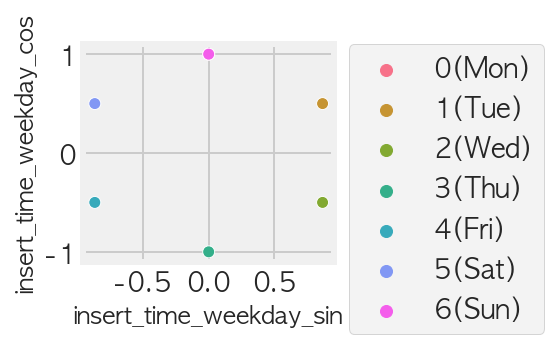

In [48]:
# weekday sin/cos 인코딩 설명 
weekday_sincos_df = train_merged_dates.head(100000).groupby(['insert_time_weekday_sin','insert_time_weekday_cos','insert_time_weekday']).count().reset_index().iloc[:,:3]
weekday_sincos_df = weekday_sincos_df.sort_values('insert_time_weekday')
weekday_sincos_df['insert_time_weekday'] = ['0(Mon)','1(Tue)','2(Wed)','3(Thu)','4(Fri)','5(Sat)','6(Sun)']

plt.figure(figsize=(2,2))
sns.scatterplot(x='insert_time_weekday_sin',y='insert_time_weekday_cos', hue='insert_time_weekday',
                data=weekday_sincos_df, )
plt.legend(bbox_to_anchor=(1.06, 1), loc='upper left', borderaxespad=0)

In [49]:
# # 파일 내보내기 
# train_merged.to_csv('train_cs_xgb_Naver_leedh.csv', index=False) 
# test_merged.to_csv('test_cs_xgb_Naver_leedh.csv', index=False) 

In [50]:
# # csv 내보내기 
# train_merged2.to_csv('train_cs_xgb_NaverLog_leedh.csv', index=False) 

## COFIX DATA

### cofix 데이터 전처리 

In [51]:
cofix2=cofix.iloc[:,1:] 
cofix2.rename(columns={"Unnamed: 1":"date","Unnamed: 2":"COFIX" }, inplace=True)

cofix2["insert_time1"]=cofix2.date.str.split('~').str[0]
cofix2["insert_time2"]=cofix2.date.str.split('~').str[1]

cofix3=cofix2.iloc[:,1:]

#date1, date2 연-월-일 (pd.Datetime) 
cofix3['insert_time1'] = pd.to_datetime(cofix3['insert_time1']) 
cofix3['insert_time2'] = pd.to_datetime(cofix3['insert_time2'])

#2월 26일 ~ 7월 1일 데이터만 
cofix4 =cofix3.loc[(cofix3["insert_time2"]<="2022-07-02")&(cofix3["insert_time1"]>="2022-02-25")] 
cofix4.tail(2)

,COFIX,insert_time1,insert_time2
30,1.57,2022-03-05,2022-03-11
31,1.57,2022-02-26,2022-03-04


In [52]:
cofix_df = pd.DataFrame({"insert_time_date": pd.date_range('2022/02/26','2022/07/01')} )
cofix_df = pd.merge(cofix_df, cofix4[['COFIX','insert_time1']], how='left', left_on=['insert_time_date'], right_on=['insert_time1']).drop(['insert_time1'],axis=1)
cofix_df = pd.merge(cofix_df, cofix4[['COFIX','insert_time2']], how='left', left_on=['insert_time_date'], right_on=['insert_time2']).drop(['insert_time2'],axis=1)

cofix_df['cofix'] = cofix_df[['COFIX_x','COFIX_y']].sum(axis=1, skipna=True, min_count=1)
cofix_df['cofix'] = cofix_df['cofix'].fillna(method="ffill")
cofix_df.drop(['COFIX_x','COFIX_y'],axis=1,inplace=True)

cofix_df.head(2)

,insert_time_date,cofix
0,2022-02-26,1.57
1,2022-02-27,1.57


In [53]:
print(cofix_df.isna().sum())

insert_time_date    0
cofix               0
dtype: int64


In [54]:
def CofixMerge(data):
    
    ## 0) 날짜형 변환 
    data['insert_time_date'] = pd.to_datetime(data['insert_time'].dt.date) 
    
    ## 1) 병합
    data = pd.merge(data, cofix_df, how='left', on=['insert_time_date'] )
    
    ## 2) 불필요한 열 제거 
    data.drop(['insert_time_date'],axis=1, inplace=True) 
    
    print('COFIX data merged.')
    
    return data 

In [55]:
train_merged_econ = CofixMerge(train_merged_dates) 
test_merged_econ = CofixMerge(test_merged_dates) 

COFIX data merged.
COFIX data merged.


In [56]:
# ## 잘 병합되었는지, na는 없는지 체크 
# print(train_merged_econ['cofix'].value_counts(dropna=False),'\n')
# print(test_merged_econ['cofix'].value_counts(dropna=False))

## 소비자 물가 데이터

In [57]:
#2월: 105.30 3월 : 106.06 4월: 106.85 5월: 107.56 6월: 108.22 - insert_time_month기준으로 lag1까지 붙이기

train_merged_econ.loc[(train_merged_econ["insert_time"].dt.month==3),"CPI"]=106.06
train_merged_econ.loc[(train_merged_econ["insert_time"].dt.month==4),"CPI"]=106.85
train_merged_econ.loc[(train_merged_econ["insert_time"].dt.month==5),"CPI"]=107.56
test_merged_econ.loc[(test_merged_econ["insert_time"].dt.month==6),"CPI"]=108.22

train_merged_econ.loc[(train_merged_econ["insert_time"].dt.month==3),"CPI_lag1"]=105.30 
train_merged_econ.loc[(train_merged_econ["insert_time"].dt.month==4),"CPI_lag1"]=106.06
train_merged_econ.loc[(train_merged_econ["insert_time"].dt.month==5),"CPI_lag1"]=106.85
test_merged_econ.loc[(test_merged_econ["insert_time"].dt.month==6),"CPI_lag1"]=107.56


#확인 
print(train_merged_econ['CPI'].value_counts(dropna=False))
print(test_merged_econ['CPI_lag1'].value_counts(dropna=False))

print(train_merged_econ['CPI'].value_counts(dropna=False))
print(test_merged_econ['CPI_lag1'].value_counts(dropna=False))

107.56    3577317
106.85    3426207
106.06    3260825
Name: CPI, dtype: int64
107.56    3255482
Name: CPI_lag1, dtype: int64
107.56    3577317
106.85    3426207
106.06    3260825
Name: CPI, dtype: int64
107.56    3255482
Name: CPI_lag1, dtype: int64


In [58]:
print(train_merged_econ.isna().sum().sum()) 
print(test_merged_econ.isna().sum().sum())  # is_applied: 2603137건, yearly_income:6건 

0
3255482


## 파생변수

In [59]:
def add_exovars(data):

    ## insert_time_diff: insert_time 차이 
    data['insert_time_diff'] = (data['loanapply_insert_time'] - data['insert_time']).astype('timedelta64[s]')
    print('insert_time_diff')
    
    ## application_id_cnt: application_id 별 행수 
    data['application_id_cnt'] = data.groupby('application_id')['user_id'].transform('size')
    print('application_id_cnt')
    
    ## diff_amount: (희망대출금액) - (승인된 대출한도)
    ## more_loan_desired: (희망대출금액) < (승인된 대출한도) 이면 1, 아니면 0
    data['diff_amount'] = data['desired_amount'] - data['loan_limit']
    data['more_loan_desired'] = (data['desired_amount'] < data['loan_limit'])
    print('diff_amount')
    print('more_loan_desired')

    ## loan_limit_outlier: loan_limit이 outlier인지 여부, outlier 기준은 Q3*1.5 = 49500000
    data['loan_limit_outlier'] = (data['loan_limit'] > (data['loan_limit'].quantile(0.75)*1.5)) 
    print('loan_limit_outlier')
    
    ## first_confirmed: 동일 application_id 내에서 가장 먼저 연 상품인지의 여부 (1/0)
    data['first_confirmed'] = False 
    data.iloc[data.sort_values('loanapply_insert_time').groupby('application_id').head(1).index, 
              data.columns.get_loc("first_confirmed")] = True  
    print('first_confirmed')
    
    
    return data

In [60]:
# 시간 다소 소요됨 
train_merged_addexo1 = add_exovars(train_merged_econ)
test_merged_addexo1 = add_exovars(test_merged_econ)

insert_time_diff
application_id_cnt
diff_amount
more_loan_desired
loan_limit_outlier
first_confirmed
insert_time_diff
application_id_cnt
diff_amount
more_loan_desired
loan_limit_outlier
first_confirmed


In [61]:
print('train_merged_addexo1: ', train_merged_addexo1.shape)
print('test_merged_addexo1: ', test_merged_addexo1.shape)

train_merged_addexo1:  (10264349, 89)
test_merged_addexo1:  (3255482, 89)


In [62]:
train_merged_addexo1.iloc[:3,-10:]

,insert_time_weekday_cos,cofix,CPI,CPI_lag1,insert_time_diff,application_id_cnt,diff_amount,more_loan_desired,loan_limit_outlier,first_confirmed
0,0.5,1.57,106.06,105.3,1.0,1,-19000000.0,True,False,True
1,0.5,1.57,106.06,105.3,1.0,1,-23000000.0,True,False,True
2,0.5,1.57,106.06,105.3,1.0,10,27000000.0,False,False,False


In [63]:
test_merged_addexo1.iloc[:3,-10:]

,insert_time_weekday_cos,cofix,CPI,CPI_lag1,insert_time_diff,application_id_cnt,diff_amount,more_loan_desired,loan_limit_outlier,first_confirmed
0,-0.5,1.97,108.22,107.56,1.0,1,-9000000.0,True,False,True
1,-0.5,1.97,108.22,107.56,0.0,1,2500000.0,False,False,True
2,-0.5,1.97,108.22,107.56,0.0,3,4000000.0,False,False,True


In [64]:
# exocols = ['insert_time_diff','application_id_cnt','diff_amount','more_loan_desired',
#            'loan_limit_outlier','first_confirmed']

# for col in exocols:
    
#     print(test_merged4[col].value_counts(dropna=False),'\n')

In [65]:
def add_exovars_ver2(data):
    
    ## 소득 대비 대출 비율 
    data['loan_income_ratio'] = data['existing_loan_amt'] / data['yearly_income']
    print('loan_income_ratio is done.') 
    
    ## loan_rate_rank, loan_limit_rank : 동일 application_id 내에서 loan_rate, loan_limit 의 순위 
    data['loan_rate_rank'] = data.groupby('application_id')['loan_rate'].rank(method='min')  # ''min', dense' 고민 
    data['loan_limit_rank'] = data.groupby('application_id')['loan_limit'].rank(method='min')  # ''min', dense' 고민 
    print('loan_rate_rank is done.') 
    print('loan_limit_rank is done.') 
    
    
    return data 

In [66]:
train_merged_addexo2 = add_exovars_ver2(train_merged_addexo1)
test_merged_addexo2 = add_exovars_ver2(test_merged_addexo1)

loan_income_ratio is done.
loan_rate_rank is done.
loan_limit_rank is done.
loan_income_ratio is done.
loan_rate_rank is done.
loan_limit_rank is done.


In [67]:
print(train_merged_addexo2.isna().sum().sum())
print(test_merged_addexo2.isna().sum().sum()) 

0
3255482


In [68]:
test_merged_addexo2.shape

(3255482, 92)

In [69]:
test_merged_addexo2.isna().sum().sum()  # 'is_applied' 만의 Na임을 확인 

3255482

In [70]:
test_merged_addexo2.isna().sum()[:20]

application_id                      0
loanapply_insert_time               0
bank_id                             0
product_id                          0
loan_limit                          0
loan_rate                           0
is_applied                    3255482
user_id                             0
birth_year                          0
gender                              0
insert_time                         0
credit_score                        0
yearly_income                       0
income_type                         0
company_enter_month                 0
employment_type                     0
houseown_type                       0
desired_amount                      0
purpose                             0
personal_rehabilitation_yn          0
dtype: int64

In [71]:
train_merged_addexo2.shape 

(10264349, 92)

In [72]:
#insert_time_month - 1,2,3 numeric 변수로 만들기 

train_merged_addexo2["insert_time_month"] = train_merged_addexo2["insert_time_month"].astype("int")-2
print(train_merged_addexo2["insert_time_month"].value_counts())

test_merged_addexo2["insert_time_month"] = test_merged_addexo2["insert_time_month"].astype("int")-2
print(test_merged_addexo2["insert_time_month"].value_counts())

3    3577317
2    3426207
1    3260825
Name: insert_time_month, dtype: int64
4    3255482
Name: insert_time_month, dtype: int64


In [73]:
train_merged_addexo2.isna().sum()

application_id           0
loanapply_insert_time    0
bank_id                  0
product_id               0
loan_limit               0
                        ..
loan_limit_outlier       0
first_confirmed          0
loan_income_ratio        0
loan_rate_rank           0
loan_limit_rank          0
Length: 92, dtype: int64

In [74]:
test_merged_addexo2.isna().sum()

application_id           0
loanapply_insert_time    0
bank_id                  0
product_id               0
loan_limit               0
                        ..
loan_limit_outlier       0
first_confirmed          0
loan_income_ratio        0
loan_rate_rank           0
loan_limit_rank          0
Length: 92, dtype: int64

## 데이터 저장하기 

In [75]:
## 파일 내보내기 
train_merged_addexo2.to_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/전처리데이터/병합완료/train_exog.csv', index=False) 
test_merged_addexo2.to_csv('/Users/baeknarim/데이터분석분야_퓨처스부문_포포나무팀/추가제출파일/DATA/전처리데이터/병합완료/test_exog.csv', index=False) 

## 끝 

#### 휴지통

In [166]:
###### 체크 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [167]:
## train 적용 
train_merged6 = BankProductGroups(train_merged5, 'bank_id', bank_cluster1, bank_cluster2, bank_cluster3)
train_merged6 = BankProductGroups(train_merged5, 'product_id', product_cluster1, product_cluster2, product_cluster3)

## test 적용 
test_merged6 = BankProductGroups(test_merged5, 'bank_id', bank_cluster1, bank_cluster2, bank_cluster3)
test_merged6 = BankProductGroups(test_merged5, 'product_id', product_cluster1, product_cluster2, product_cluster3)

# ## test NA 처리
# train_merged6, train_merged6 = bpGroup_ReplaceTestNA(train_merged6, test_merged6) 

NameError: name 'train_merged5' is not defined

In [ ]:
train_merged6_check = train_merged6.copy()
test_merged6_check = test_merged6.copy()

In [ ]:
data_check = pd.concat([train_merged6_check, test_merged6_check], axis=0).reset_index(drop=True)
train_index = train_merged6_check.shape[0]   ################# train!!

In [ ]:
pd.concat([train_merged6_check, test_merged6_check], axis=0).reset_index(drop=True)['product_group'].isna().sum()

In [ ]:
data_check['product_group'] = data_check.groupby('product_id')['product_group'].ffill()

In [ ]:
data_check['product_group'].isna().sum()

In [ ]:
data_check[data_check['product_group'].isna()]['product_id'].value_counts()

In [99]:
        na_products = list(set(data_check.loc[data_check['product_group'].isna(), 'product_id']))
        notNA_df = data_check[data_check['product_group'].notna()] 

In [100]:
na_products

[241, 178, 101]

In [83]:
        i = 1
    
        ## 현재 NA인 bank_popularity 의 loan_rate 최댓값 
        loan_rate_NA_max = data.loc[data['bank_id'] == na_banks[i],'loan_rate'].max() 
        # loan_rate 차이가 최소인 열 구하기 
        min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
#         # 그 열들의 평균 bank_popularity 
#         data.loc[data['bank_id'] == na_banks[i], 'bank_group'] = np.nanmean(
#                     notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_group")])   

        
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['product_id'] == na_products[i], 'product_group'] = np.nanmean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_group")])

In [101]:
loan_rate_NA_max = data_check.loc[data_check['product_id'] == na_products[i],'loan_rate'].max()

In [102]:
loan_rate_NA_max

10.3

In [103]:
min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()

In [104]:
min_diff_idx

219

In [105]:
data_check.loc[data_check['product_id'] == na_products[i], 'product_group'] = np.nanmean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_group")])

In [106]:
data_check['product_group'].isna().sum()

2623

In [107]:
na_products[i]

241

In [86]:
min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()

In [87]:
min_diff_idx

2531424

In [91]:
np.nanmean(notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_group")])

4.0

In [92]:
# 그 열들의 평균 bank_popularity 
data_check.loc[data_check['bank_id'] == na_banks[i], 'bank_group'] = np.nanmean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_group")]) 

In [93]:
data_check['bank_group'].isna().sum()

0

In [ ]:
## 현재 NA인 product_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()
            
#             # loan_rate 차이가 최소인 열 구하기 
#             min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
#             # 그 열들의 평균 bank_popularity 
#             data.loc[data['product_id'] == na_products[i], 'product_popularity'] = np.nanmean(
#                     notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_popularity")])

            # loan_rate 차이가 최소인 값 구하기 
            min_diff = (loan_rate_NA_max - notNA_df['loan_rate']).abs().min()
            # 그 값을 갖는 열들의 평균 bank_popularity 
            data.loc[data['product_id'] == na_products[i], 'product_popularity'] = np.median(
                notNA_df.loc[(loan_rate_NA_max - notNA_df['loan_rate']).abs() == min_diff, 'product_popularity']) 

In [ ]:
loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()

In [ ]:
loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()

In [119]:
################### 확인 

# loan = datatable.fread('loan_result.csv', encoding='utf-8').to_pandas()  
# loan = loan.dropna(subset=['loan_limit','loan_rate'], axis=0)

# train_df = loan[loan.is_applied.notna()]
# test_df = loan[loan.is_applied.isna()]

# train_df2 = train_df.copy()
# test_df2 = test_df.copy()

In [188]:
################# 확인 2 

# train = datatable.fread('train,test_1013/train_na.csv', encoding='utf-8').to_pandas()  
# test = pd.read_csv('train,test_1013/test_na.csv', encoding='utf-8')

train = datatable.fread('train,test_1013/train_notna.csv', encoding='utf-8').to_pandas()  
test = pd.read_csv('train,test_1013/test_notna.csv', encoding='utf-8')

In [189]:
train_df2 = train.copy()
test_df2 = test.copy() 

In [190]:
def add_popularity(train, test):     
    
    full_data = pd.concat([train, test], axis=0).reset_index(drop=True)
    train_index = train.shape[0] 
    
    full_data['is_applied'] = full_data['is_applied'].astype(float)
    
    ## popularity 계산을 위해 loanapply_insert_time -> loanapply_insert_time (초 단위), 이후 제거 
    refer_time = dt.datetime(2022, 2, 28) 
    full_data['loanapply_insert_time'] = pd.to_datetime(full_data['loanapply_insert_time']) 
    full_data['loanapply_insert_time_s'] = (full_data['loanapply_insert_time'] - refer_time).dt.total_seconds().astype(int)  
    
    ## bank_popularity: 은행의 인기도 
    full_data['bank_cumcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('bank_id').cumcount() + 1
    full_data['bank_cumappliedcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('bank_id')['is_applied'].cumsum()
    full_data['bank_popularity'] = full_data['bank_cumappliedcnt'] / full_data['bank_cumcnt'] 
    full_data.drop(['bank_cumappliedcnt'],axis=1,inplace=True) 
    full_data[['bank_cumcnt','bank_popularity']].fillna(0, inplace=True)
    print('bank_cumcnt is done.')
    print('bank_popularity is done.')
    
    ## product_popularity: 상품의 인기도 
    full_data['product_cumcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('product_id').cumcount() + 1
    full_data['product_cumappliedcnt'] = full_data.sort_values(by='loanapply_insert_time_s').groupby('product_id')['is_applied'].cumsum()
    full_data['product_popularity'] = full_data['product_cumappliedcnt'] / full_data['product_cumcnt'] 
    full_data.drop(['product_cumappliedcnt'],axis=1,inplace=True) 
    full_data[['product_cumcnt','product_popularity']].fillna(0, inplace=True)
    print('product_cumcnt is done.') 
    print('product_popularity is done.')
    
    full_data['is_applied'] = full_data['is_applied'].fillna(-1).astype(int).astype(str).replace('-1', np.nan)
    
    train = full_data.loc[full_data.index.isin(np.arange(train_index))]
    test = full_data.loc[~full_data.index.isin(np.arange(train_index))]
    
    return train, test

In [191]:
print(train_df2.isna().sum(0))
print(test_df2.isna().sum(0))

application_id                         0
loanapply_insert_time                  0
bank_id                                0
product_id                             0
loan_limit                             0
loan_rate                              0
is_applied                             0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
company_enter_year                     0
dtype: int64
app

In [192]:
train_df3, test_df3 = add_popularity(train_df2, test_df2)

bank_cumcnt is done.
bank_popularity is done.
product_cumcnt is done.
product_popularity is done.


In [193]:
print(train_df3.isna().sum(0))
print(test_df3.isna().sum(0))

application_id                         0
loanapply_insert_time                  0
bank_id                                0
product_id                             0
loan_limit                             0
loan_rate                              0
is_applied                             0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
company_enter_year                     0
loanapply_insert

In [194]:
def popularity_ReplaceTestNA(train, test):  
    
    
    data = pd.concat([train, test], axis=0).reset_index(drop=True)
    train_index = train.shape[0] 
    
    ## 1) bank_popularity NA 처리 

    
#     #만일 bank_popularity, product_popularity Na 있으면, loan_rate 차이 적은 bank_id, product_id 의 popularity로 대체 
#     full_data['bank_popularity'].fillna((full_data['bank_popularity'].mean()), inplace=True)
#     full_data['product_popularity'].fillna((full_data['product_popularity'].mean()), inplace=True)

#     full_data['is_applied'] = full_data['is_applied'].astype(float)
    
    # bank_popularity 가 결측이면 
    if data['bank_popularity'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 bank_id 일 경우 
        data['bank_popularity'] = data.groupby('bank_id')['bank_popularity'].ffill()  # train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        
        
        # 케이스 2) train에 없는 새로 생긴 bank_id 일 경우
        
        # bank_popularity 가 NA인 user_id 리스트 
        na_banks = list(set(data.loc[data['bank_popularity'].isna(), 'bank_id']))
        notNA_df = data[data['bank_popularity'].notna()] 

        for i in range(len(na_banks)): 

            ## 현재 NA인 bank_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['bank_id'] == na_banks[i],'loan_rate'].max() 
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['bank_id'] == na_banks[i], 'bank_popularity'] = np.mean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_popularity")])
        print('bank_popularity NA is done.') 
        
    
    ## 2) product_popularity  NA 처리 
    if data['product_popularity'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 product_id 일 경우 
        data['product_popularity'] = data.groupby('product_id')['product_popularity'].ffill()  # train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        
    
        # 케이스 2) train에 없는 새로 생긴 product_id 일 경우
    
        # product_popularity 가 NA인 user_id 리스트 
        na_products = list(set(data.loc[data['product_popularity'].isna(), 'product_id']))
        notNA_df = data[data['product_popularity'].notna()]

        for i in range(len(na_products)): 
            
            ## 현재 NA인 product_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['product_id'] == na_products[i], 'product_popularity'] = np.mean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_popularity")])
        print('product_popularity NA is done.')     
            
    
    train = data.loc[data.index.isin(np.arange(train_index))]
    test = data.loc[~data.index.isin(np.arange(train_index))]
    
    return train, test 

In [195]:
train_df4, test_df4 = popularity_ReplaceTestNA(train_df3, test_df3)

bank_popularity NA is done.
product_popularity NA is done.


In [196]:
print(train_df4.isna().sum(0))
print(test_df4.isna().sum(0))

application_id                         0
loanapply_insert_time                  0
bank_id                                0
product_id                             0
loan_limit                             0
loan_rate                              0
is_applied                             0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
company_enter_year                     0
loanapply_insert

In [197]:
# 은행 분류 정의 (EDA 결과를 바탕으로)
bank_cluster1= [55, 14, 44, 21, 42, 38, 34, 46, 29, 39, 15, 6, 61, 64, 13, 57, 32, 20, 35, 59, 31, 50, 27, 7, 25, 36, 1, 26, 24, 54, 22, 49, 8, 37, 58, 12, 43, 19, 33, 47, 30, 28, 10, 41, 18, 62, 17, 5, 63, 23, 11, 51, 45, 40, 56, 4, 2, 16, 52, 9]
bank_cluster2= [29, 55, 42, 3, 46, 21, 14, 64, 15, 20, 57, 39, 35, 52, 44, 27, 59, 8, 45, 54, 50, 43, 26, 1, 61, 49, 31, 37, 58, 12, 36, 7, 25, 38, 19, 47, 18, 22, 62, 30, 5, 33, 24, 63, 23, 32, 40, 60, 28, 41, 56, 4, 16, 17, 2, 9]
bank_cluster3= [13, 55, 35, 38, 64, 15, 34, 3, 6, 24, 14, 44, 37, 46, 21, 32, 57, 61, 42, 1, 43, 36, 20, 59, 25, 22, 50, 11, 26, 54, 49, 7, 31, 58, 12, 19, 33, 30, 47, 28, 10, 41, 17, 5, 63, 23, 40, 51, 56, 2]

# 대출상품 분류 정의 (EDA 결과를 바탕으로)
product_cluster1= [12, 128, 171, 196, 216, 113, 8, 215, 140, 197, 227, 265, 62, 204, 36, 92, 25, 258, 141, 254, 186, 262, 71, 56, 111, 249, 51, 15, 38, 150, 239, 174, 142, 176, 220, 191, 245, 90, 185, 163, 192, 67, 61, 80, 263, 259, 157, 82, 70, 1, 221, 60, 91, 39, 144, 31, 107, 206, 243, 175, 29, 68, 58, 224, 35, 246, 168, 147, 231, 264, 110, 138, 121, 235, 217, 266, 267, 96, 149, 65, 222, 26, 223, 16, 139, 114, 49, 78, 85, 40, 131, 200, 19, 194, 226, 233, 236, 108, 170, 169, 162, 270, 57, 20, 43, 247, 86, 22, 161, 129, 146, 252, 94, 98, 30, 79, 5, 81, 240, 59, 248, 123, 268, 137, 93, 42, 124, 24, 211, 238, 100, 126, 7, 181, 166, 187, 159, 250]
product_cluster2= [265, 25, 258, 205, 227, 196, 128, 254, 152, 141, 111, 12, 71, 62, 216, 197, 38, 249, 234, 171, 148, 251, 187, 91, 270, 119, 259, 22, 31, 142, 246, 80, 90, 8, 185, 1, 144, 245, 92, 195, 136, 244, 206, 39, 175, 140, 68, 61, 35, 15, 60, 191, 75, 224, 163, 58, 103, 134, 127, 47, 223, 16, 78, 235, 131, 188, 94, 176, 49, 138, 96, 164, 200, 48, 121, 194, 189, 229, 20, 226, 184, 236, 266, 257, 261, 129, 267, 157, 183, 63, 217, 51, 110, 174, 30, 263, 161, 222, 162, 5, 108, 59, 67, 268, 137, 225, 264, 233, 42, 147, 168, 146, 166, 220, 238, 19, 26, 7, 181, 55, 250, 105, 190]
product_cluster3= [123, 12, 29, 262, 113, 254, 204, 215, 15, 205, 36, 263, 197, 239, 152, 8, 192, 38, 141, 206, 186, 25, 227, 140, 196, 56, 71, 92, 128, 258, 171, 61, 246, 157, 111, 67, 150, 169, 221, 216, 142, 118, 80, 163, 107, 70, 168, 245, 81, 1, 259, 39, 191, 220, 174, 266, 243, 249, 175, 35, 90, 68, 159, 185, 60, 51, 144, 161, 91, 231, 110, 85, 138, 86, 217, 49, 98, 223, 16, 65, 149, 235, 57, 139, 222, 264, 40, 19, 194, 100, 43, 226, 170, 79, 108, 236, 233, 129, 252, 26, 162, 267, 224, 147, 46, 30, 5, 124, 248, 247, 121, 114, 58, 137, 126, 93, 24, 146, 7, 181]

    
## bank_group: bank의 loan_rate, loan_limit을 기준으로 그룹핑 
def BankProductGroups(data, variable, cluster1, cluster2, cluster3):
    
    ## 차집합을 이용해 7개의 클러스터로 나눔
    c123 = list(set(cluster1) & set(cluster2) & set(cluster3)) 

    c1 = list((set(cluster1) - set(cluster2)) - set(cluster3))
    c2 = list((set(cluster2) - set(cluster3)) - set(cluster1))
    c3 = list((set(cluster3) - set(cluster1)) - set(cluster2))

    c12 = list((set(cluster1) & set(cluster2)) - set(c123))
    c23 = list((set(cluster2) & set(cluster3)) - set(c123))
    c31 = list((set(cluster3) & set(cluster1)) - set(c123))

    clusters_list = [c1, c2, c3, c12, c23, c31, c123]

    ## 내용이 없는 클러스터일 경우 삭제 
    clusters_list = [cluster for cluster in clusters_list if cluster != []]
#     print(clusters_list)
    
    ## bank_group, product_group: bank_id 를 loan_rate,loan_limit 이용해 clustering 한 결과 
    for i, value in enumerate(clusters_list):
        
        # 각 group 에 속한 bank_id 혹은 product_id 를 확인할 수 있음 
#         print(str(variable), 'cluster: ', (i+1), value)
        print('cluster ', str(i), 'len: ', len(value), '\n', value)
        
        if variable == 'bank_id':
            data.loc[data[variable].isin(value), 'bank_group'] = i+1
        elif variable == 'product_id':
            data.loc[data[variable].isin(value), 'product_group'] = i+1 
    
    print(str(variable), 'group done.') 
    print('\n')

    return data 

In [198]:
def bpGroup_ReplaceTestNA(train, test):  
    
    
    data = pd.concat([train, test], axis=0).reset_index(drop=True)
    train_index = train.shape[0] 
    
    ## 1) bank_group NA 처리 
      
    # bank_group 가 결측이면 
    if data['bank_group'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 bank_id 일 경우 
        ## train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        
        data['bank_group'] = data.groupby('bank_id')['bank_group'].ffill()  
        
        # 케이스 2) train에 없는 새로 생긴 bank_id 일 경우
        
        # bank_popularity 가 NA인 user_id 리스트 
        na_banks = list(set(data.loc[data['bank_group'].isna(), 'bank_id']))
        notNA_df = data[data['bank_group'].notna()] 

        for i in range(len(na_banks)): 

            ## 현재 NA인 bank_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['bank_id'] == na_banks[i],'loan_rate'].max() 
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['bank_id'] == na_banks[i], 'bank_group'] = np.mean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("bank_group")])
        print('bank_group NA is done.') 
        
    
    ## 2) product_group  NA 처리 
    if data['product_group'].isna().sum() != 0 :
        
        # 케이스 1) train에 존재하는 product_id 일 경우 
        # train의 가장 마지막 값으로 채우기 (mle 수렴한다고 가정)
        data['product_group'] = data.groupby('product_id')['product_group'].ffill()  
    
        # 케이스 2) train에 없는 새로 생긴 product_id 일 경우
    
        # product_popularity 가 NA인 user_id 리스트 
        na_products = list(set(data.loc[data['product_group'].isna(), 'product_id']))
        notNA_df = data[data['product_group'].notna()]

        for i in range(len(na_products)): 
            
            ## 현재 NA인 product_popularity 의 loan_rate 최댓값 
            loan_rate_NA_max = data.loc[data['product_id'] == na_products[i],'loan_rate'].max()
            # loan_rate 차이가 최소인 열 구하기 
            min_diff_idx = (loan_rate_NA_max - notNA_df['loan_rate']).abs().idxmin()
            # 그 열들의 평균 bank_popularity 
            data.loc[data['product_id'] == na_products[i], 'product_group'] = np.mean(
                    notNA_df.iloc[min_diff_idx, notNA_df.columns.get_loc("product_group")])
        print('product_group NA is done.')     
            
    
    train = data.loc[data.index.isin(np.arange(train_index))]
    test = data.loc[~data.index.isin(np.arange(train_index))]
    
    return train, test 

In [102]:
## train 적용  # train_df4, test_df4
train_df5 = BankProductGroups(train_df4, 'bank_id', bank_cluster1, bank_cluster2, bank_cluster3)
train_df5 = BankProductGroups(train_df4, 'product_id', product_cluster1, product_cluster2, product_cluster3)

## test 적용 
test_df5 = BankProductGroups(test_df4, 'bank_id', bank_cluster1, bank_cluster2, bank_cluster3)
test_df5 = BankProductGroups(test_df4, 'product_id', product_cluster1, product_cluster2, product_cluster3)

NameError: name 'train_df4' is not defined

In [200]:
print(train_df5.isna().sum(0))
print(test_df5.isna().sum(0))

application_id                         0
loanapply_insert_time                  0
bank_id                                0
product_id                             0
loan_limit                             0
loan_rate                              0
is_applied                             0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
company_enter_year                     0
loanapply_insert

In [101]:
## test NA 처리
train_df6, test_df6 = bpGroup_ReplaceTestNA(train_df5, test_df5)

NameError: name 'train_df5' is not defined

In [202]:
print(train_df6.isna().sum(0))
print(test_df6.isna().sum(0))

application_id                         0
loanapply_insert_time                  0
bank_id                                0
product_id                             0
loan_limit                             0
loan_rate                              0
is_applied                             0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
company_enter_year                     0
loanapply_insert

In [203]:
train_df6

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,existing_loan_cnt,existing_loan_amt,company_enter_year,loanapply_insert_time_s,bank_cumcnt,bank_popularity,product_cumcnt,product_popularity,bank_group,product_group
0,180433,2022-03-01 00:12:05,19,231,16000000.0,15.0,0,623737,1997.0,1.0,...,3.0,11000000.0,2022.0,87125,1,0.000000,1,0.000000,5.0,6.0
1,180433,2022-03-01 00:12:05,13,262,22000000.0,16.6,0,623737,1997.0,1.0,...,3.0,11000000.0,2022.0,87125,1,0.000000,1,0.000000,4.0,6.0
2,180433,2022-03-01 00:12:06,21,196,3000000.0,10.9,1,623737,1997.0,1.0,...,3.0,11000000.0,2022.0,87126,1,1.000000,1,1.000000,5.0,7.0
3,1657888,2022-03-01 00:12:06,24,263,5000000.0,15.9,0,752985,1997.0,1.0,...,7.0,33000000.0,2021.0,87126,1,0.000000,1,0.000000,5.0,7.0
4,1657888,2022-03-01 00:12:06,42,216,3000000.0,13.5,0,752985,1997.0,1.0,...,7.0,33000000.0,2021.0,87126,1,0.000000,1,0.000000,5.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7733091,455157,2022-05-31 23:54:28,35,168,3000000.0,18.3,0,717233,1973.0,1.0,...,12.0,293000000.0,1997.0,8034868,441005,0.028954,123237,0.017990,5.0,7.0
7733092,455157,2022-05-31 23:54:28,55,159,3000000.0,18.9,0,717233,1973.0,1.0,...,12.0,293000000.0,1997.0,8034868,126226,0.012406,12893,0.022027,5.0,6.0
7733093,455157,2022-05-31 23:54:29,22,221,5000000.0,18.4,0,717233,1973.0,1.0,...,12.0,293000000.0,1997.0,8034869,214358,0.029903,105765,0.038841,5.0,6.0
7733094,455157,2022-05-31 23:54:37,38,16,3000000.0,14.5,0,717233,1973.0,1.0,...,12.0,293000000.0,1997.0,8034877,381835,0.047620,109557,0.015809,5.0,7.0


In [204]:
test_df6

,application_id,loanapply_insert_time,bank_id,product_id,loan_limit,loan_rate,is_applied,user_id,birth_year,gender,...,existing_loan_cnt,existing_loan_amt,company_enter_year,loanapply_insert_time_s,bank_cumcnt,bank_popularity,product_cumcnt,product_popularity,bank_group,product_group
7733096,506292,2022-06-01 00:12:24,27,148,13000000.0,7.2,NaN,669202,1981.0,1.0,...,1.0,6.299001e+07,2022.0,8035944,217653,0.073907,87541,0.082854,2.0,2.0
7733097,506292,2022-06-01 00:12:24,59,251,11000000.0,6.8,NaN,669202,1981.0,1.0,...,1.0,6.299001e+07,2022.0,8035944,299533,0.108473,121466,0.186803,5.0,2.0
7733098,506292,2022-06-01 00:12:24,19,231,24000000.0,15.6,NaN,669202,1981.0,1.0,...,1.0,6.299001e+07,2022.0,8035944,205488,0.049137,66382,0.048809,5.0,6.0
7733099,506292,2022-06-01 00:12:25,56,5,2000000.0,18.5,NaN,669202,1981.0,1.0,...,1.0,6.299001e+07,2022.0,8035945,59150,0.071785,59150,0.071785,5.0,7.0
7733100,506292,2022-06-01 00:12:34,19,127,13000000.0,9.5,NaN,669202,1981.0,1.0,...,1.0,6.299001e+07,2022.0,8035954,205489,0.049137,108515,0.060333,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10336228,1495740,2022-06-30 23:54:07,55,144,34000000.0,13.6,NaN,274137,1980.0,1.0,...,3.0,4.500000e+07,2020.0,10626847,169362,0.012406,14207,0.013068,5.0,7.0
10336229,1495740,2022-06-30 23:54:13,8,31,6000000.0,9.5,NaN,274137,1980.0,1.0,...,3.0,4.500000e+07,2020.0,10626853,118549,0.112504,81558,0.143277,2.0,4.0
10336230,634459,2022-06-30 23:54:48,19,231,11000000.0,16.6,NaN,244440,2000.0,1.0,...,1.0,6.299001e+07,2022.0,10626888,283973,0.049137,97348,0.048809,5.0,6.0
10336231,634459,2022-06-30 23:54:48,10,149,30000000.0,14.5,NaN,244440,2000.0,1.0,...,1.0,6.299001e+07,2022.0,10626888,325535,0.031744,159437,0.034740,4.0,6.0


#### 휴지통 끝